# returnChartData
Returns candlestick chart data. 
Required GET parameters are :
* "currencyPair", 
* "period" (candlestick period in seconds; valid values are 300, 900, 1800, 7200, 14400, and 86400), 
* "start", 
* "end".

"Start" and "end" are given in UNIX timestamp format and used to specify the date range for the data returned. 

Call: https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XMR&start=1405699200&end=9999999999&period=14400

Sample output:

>`[{"date":1405699200,"high":0.0045388,"low":0.00403001,"open":0.00404545,"close":0.00427592,"volume":44.11655644,
"quoteVolume":10259.29079097,"weightedAverage":0.00430015}, ...]`

# Le probleme du temps

Gros problème rencontré pour l'interprétation du temps :
* les données fournies par le broker sont de type UNIX
* la fonction candlestick_ohlc prends des data en format "float"

Je n'ai pas réussis a faire la conversion directe Unix vers Float,

Alors, je transforme les dates unix en dates de type datetime.datetime avec la commande
>datetime.datetime.fromtimstamp()

Ce qui me permet d'obtenir une classe datetime.
   Ensuite, sur cet objet datetime, je peux appeler la méthode "date2num()" qui prend en parametre un datetime et qui renvoit sa valeur en format float.


### Note sur JSON
La sortie de data.read() est un fichier de type byte qui est pas terriblement formate.
On utilise JSON et la fonction loads :
    
https://docs.python.org/3/library/json.html
>JSON (JavaScript Object Notation), specified by RFC 7159 and by ECMA-404, is a lightweight data interchange format inspired by JavaScript object literal syntax.
    
    >`json.loads(s, *, encoding=None, cls=None, object_hook=None, parse_float=None, parse_int=None, parse_constant=None, object_pairs_hook=None, **kw)`

>Deserialize s (a str, bytes or bytearray instance containing a JSON document) to a Python object using this conversion table.
    

Cela permet de recuperer les données sous forme d'une liste de dictionnaires

In [1]:
import urllib
import json
import time
import datetime
from datetime import date
from matplotlib.finance import date2num
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

C:\Users\Roger\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def return_chart(currencyPair, start, end, *period):
    
    # if no period is given, the default period will be 14400 seconds 
    if not period:
        period = str(14400)
    else:
        period = str(period[0])
    
    end = str(time.mktime(end.timetuple()))
    start = str(time.mktime(start.timetuple()))
    urlQuotes = urllib.request.urlopen('https://poloniex.com/public?command=returnChartData&currencyPair=' + currencyPair
                                           + '&start=' + start
                                           + '&end=' + end
                                           + '&period=' + period)
                                     
    rawQuotes = urlQuotes.read()
    ## permet de lire correctement les data au format JSON
    data = json.loads(rawQuotes)
    
    return data
    

In [3]:
def candlestick(data):
    date_time=[]
    close=[]
    high=[]
    low=[]
    open=[]
    
    for i in data:
        close.append(i.get("close"))
        date_time.append(i.get("date"))
        high.append(i.get("high"))
        low.append(i.get("low"))
        open.append(i.get("open"))
        
        
    #regler le probleme des differents formats de temps
    k=0
    for k in range(len(date_time)):
        date_time[k]=date2num(datetime.datetime.fromtimestamp(date_time[k]))
        k+=1

    quotes = [tuple([date_time[i],
                     open[i],
                     high[i],
                     low[i],
                     close[i]]) for i in range(len(date_time))] 

### Ploter le candlestick chart
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    f1 = plt.subplot2grid((6, 4), (1, 0), rowspan=6, colspan=4)
    
    candlestick_ohlc(f1, quotes, width=0.1, colorup='#53c156', colordown='#ff1717')

    f1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    f1.grid(True)
    plt.xticks(rotation=45)
    plt.title('Pair currency')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()


In [8]:
end = date(2017, 9, 20)
start = date(2017, 6, 1)

#candlestick(return_chart('BTC_ETH', start, end))

In [9]:
test = return_chart("BTC_ETH", start, end)
test


[{'close': 0.1003,
  'date': 1496246400,
  'high': 0.1025,
  'low': 0.0942,
  'open': 0.09962181,
  'quoteVolume': 207496.73194164,
  'volume': 20247.8749835,
  'weightedAverage': 0.09758165},
 {'close': 0.0996949,
  'date': 1496260800,
  'high': 0.10149998,
  'low': 0.0985257,
  'open': 0.10021,
  'quoteVolume': 87452.17773448,
  'volume': 8729.21004213,
  'weightedAverage': 0.09981695},
 {'close': 0.09815001,
  'date': 1496275200,
  'high': 0.09988187,
  'low': 0.09511,
  'open': 0.09969999,
  'quoteVolume': 131480.03788829,
  'volume': 12824.56878861,
  'weightedAverage': 0.09754004},
 {'close': 0.09576917,
  'date': 1496289600,
  'high': 0.09900604,
  'low': 0.09576917,
  'open': 0.09826996,
  'quoteVolume': 91258.08939384,
  'volume': 8881.90936093,
  'weightedAverage': 0.09732736},
 {'close': 0.09310001,
  'date': 1496304000,
  'high': 0.09649899,
  'low': 0.09282109,
  'open': 0.09576918,
  'quoteVolume': 120327.05074744,
  'volume': 11375.59286477,
  'weightedAverage': 0.094538

In [10]:
import pandas as pd
import numpy as np

In [12]:
df2 = pd.DataFrame(test)


date_pd = pd.to_datetime(df2['date'], unit='s')
df2 = df2.set_index(date_pd)
df2.to_csv('btc_eth.csv')

close = df2['close']
daily_test = df2.resample('D').mean()

#df2['mvg_40']= close.rolling(window=40, min_periods=1).mean()
#df2['mvg_250']= close.rolling(window=250, min_periods=1).mean()

daily_test



,close,date,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,,
2017-05-31,0.099997,1496253600,0.102000,0.096363,0.099916,147474.454838,14488.542513,0.098699
2017-06-01,0.093678,1496311200,0.096187,0.091772,0.095087,113908.096228,10707.007743,0.094004
2017-06-02,0.091620,1496397600,0.093828,0.090450,0.091918,58828.489225,5432.683940,0.092164
2017-06-03,0.088358,1496484000,0.089864,0.087190,0.088585,54446.692055,4803.479413,0.088421
2017-06-04,0.095578,1496570400,0.097209,0.092723,0.094072,102461.505289,9803.790257,0.095320
2017-06-05,0.094277,1496656800,0.095951,0.093662,0.095182,54031.102144,5117.855789,0.094727
2017-06-06,0.091230,1496743200,0.092868,0.089039,0.091231,71799.209743,6519.411519,0.091008
2017-06-07,0.093202,1496829600,0.093755,0.092136,0.092769,37391.949527,3485.885320,0.092923
2017-06-08,0.093178,1496916000,0.094246,0.092590,0.093553,31778.480215,2968.379481,0.093396


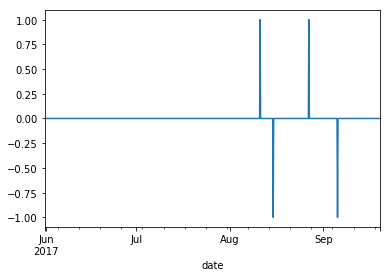

In [13]:
## Strategie

shortWindow = 40
longWindow = 200

signals = pd.DataFrame(index=df2.index)
signals['signal'] = 0.0

signals['short_mvg']=df2['close'].rolling(window=shortWindow, min_periods=1).mean()
signals['long_mvg']=df2['close'].rolling(window=longWindow, min_periods=1).mean()

signals['signal'][longWindow:] = np.where(signals['short_mvg'][longWindow:] >
                                          signals['long_mvg'][longWindow:], 1.0, 0.0)

signals['position'] = signals['signal'].diff()

signals['position'].plot()
plt.savefig('strategie')
plt.show()


## Note sur le plot de marqueurs 

J'ai essayé de ploter des triangles au moment du signal d'achat ou de vente, d'apres le code de :  
https://www.datacamp.com/community/tutorials/finance-python-trading#gs.bk8sBqM
>`#Plot the buy signals`  
>`ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')`
         
         >`#Plot the sell signals`   
>`ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')`
         
Le problème est qu'avec ces commandes, les triangles ne se plottent pas sur la figure (beug?). Si je ne plote que les triangles, ca fonctionne, mais dès que je plot d'autres data (moving average, quote...), ils disparaissent.  
J'ai donc utilisé une autre solution qui est de créer une nouvelle colonne dans le DataFrame de panda, où les valeurs sont celles de la moving average au moment de prise de position :  
* x = date au moment de la prise de position (`signals.short_mvg[signals.position == 1.0]`)  
* y = valeur de la short moyenne mobile court terme  

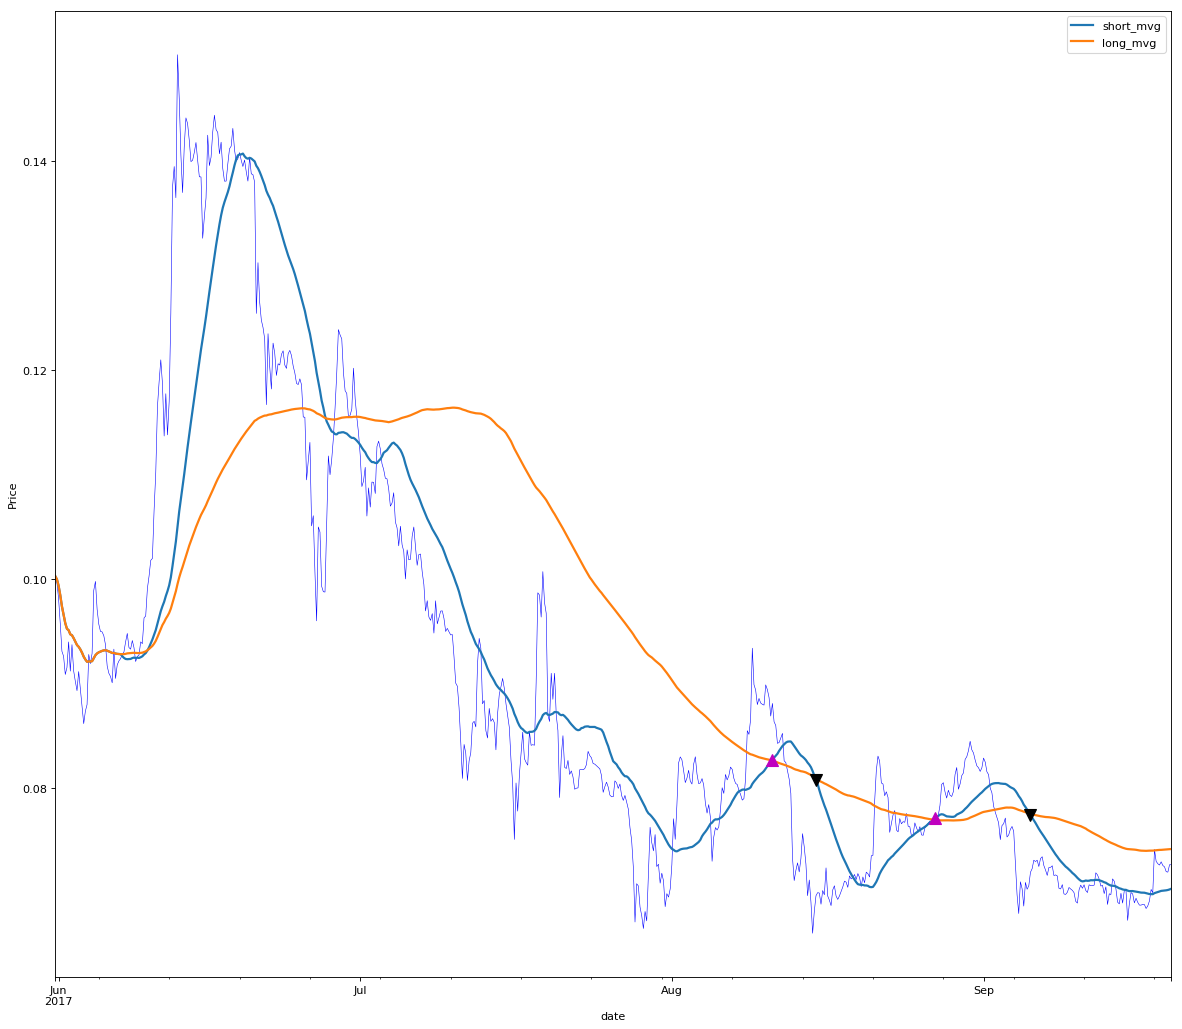

In [14]:
fig = plt.figure(figsize=(18, 16), dpi= 80)

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price')

# Plot the closing price
df2['close'].plot(color='b', lw=0.5)

# Plot the short and long moving averages
signals[['short_mvg', 'long_mvg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
df2['buy_signal'] = signals.short_mvg[signals.position == 1.0]
df2.buy_signal[df2.buy_signal > 0].plot(marker='^', markersize=10, color='m', linestyle="None")
         
# Plot the sell signals
df2['sell_signal'] = signals.short_mvg[signals.position == -1.0]
df2.sell_signal[df2.sell_signal > 0].plot(marker='v', markersize=10, color='k', linestyle="None")
df2.sell_signal[df2.sell_signal.isnull() == False]
        
# Show the plot
plt.savefig('MA.png')
plt.show()

## Note sur le boolean indexing avec Panda

>Boolean indexing
>Another common operation is the use of boolean vectors to filter the data.   
The operators are: | for or, & for and, and ~ for not. **These must be grouped by using parentheses.**  
>ex : `s[(s < -1) | (s > 0.5)]`

In [15]:



#df2.loc[(df2.sell_signal.isnull() == False) | (df2.buy_signal.isnull() == False)].iloc[0]

df2.loc[(df2.sell_signal.isnull() == False) | (df2.buy_signal.isnull() == False)]


,close,date,high,low,open,quoteVolume,volume,weightedAverage,buy_signal,sell_signal
date,,,,,,,,,,
2017-08-11 00:00:00,0.088112,1502409600,0.088425,0.086670,0.086998,17190.526158,1502.644612,0.087411,0.082703,NaN
2017-08-15 08:00:00,0.069706,1502784000,0.071401,0.067713,0.068200,71651.554093,5010.680385,0.069931,NaN,0.080815
2017-08-27 04:00:00,0.077133,1503806400,0.077675,0.076694,0.076886,8458.263482,652.228312,0.077111,0.077103,NaN
2017-09-05 16:00:00,0.071950,1504627200,0.072061,0.070355,0.070726,22468.558142,1601.947233,0.071297,NaN,0.077447


In [33]:
signals

,signal,short_mvg,long_mvg,position
date,,,,
2017-05-31 16:00:00,0.0,0.100300,0.100300,NaN
2017-05-31 20:00:00,0.0,0.099997,0.099997,0.0
2017-06-01 00:00:00,0.0,0.099382,0.099382,0.0
2017-06-01 04:00:00,0.0,0.098479,0.098479,0.0
2017-06-01 08:00:00,0.0,0.097403,0.097403,0.0
2017-06-01 12:00:00,0.0,0.096606,0.096606,0.0
2017-06-01 16:00:00,0.0,0.095788,0.095788,0.0
2017-06-01 20:00:00,0.0,0.095258,0.095258,0.0
2017-06-02 00:00:00,0.0,0.095118,0.095118,0.0


In [31]:
for i in signals['signal']:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [16]:
initial_capital = 1.0
positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions['ETH'] = 100 * signals['signal']
portfolio = positions.multiply(df2.close, axis=0)

pos_diff = positions.diff()
portfolio['holdings'] = (positions.multiply(df2.close, axis = 0))


portfolio['cash'] = initial_capital - (pos_diff.multiply(df2.close, axis = 0)).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change().cumsum()

In [27]:
for i in portfolio['holdings']:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(18, 16), dpi= 50)

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio[['total', 'returns']].plot(ax=ax1, lw=2.)


# Show the plot
plt.show()

In [ ]:
portfolio.returns[-1]

In [ ]:
portfolio['test'] = (positions.multiply(df2.close, axis = 0)).sum(axis=1)
portfolio['test2'] = (positions.multiply(df2.close, axis = 0))

In [ ]:
portfolio.test.equals(portfolio.test2)